# Python之建模规划篇
* 线性规划
* 整数规划
* 非线性规划

![](./img/P4_1.png)

In [2]:
# 1.1 scipy库求解
'''
from scipy import optimize
import numpy as np
# 求解函数
res = optimize.linprog(c, A, b, Aeq, beq, LB, UB, X0, OPTIONS)
# 目标函数最小值
print(res.fun)
# 最优解
print(res.x)
'''

'\nfrom scipy import optimize\nimport numpy as np\n# 求解函数\nres = optimize.linprog(c, A, b, Aeq, beq, LB, UB, X0, OPTIONS)\n# 目标函数最小值\nprint(res.fun)\n# 最优解\nprint(res.x)\n'

![](./img/P4_2.png)

In [4]:
from scipy import optimize
import numpy as np

#确定c，A，b，Aeq，Beq
c = np.array([2, 3, -5])
A = np.array([[-2, 5, -1], [1, 3, 1]])
b = np.array([-10, 12])
Aeq = np.array([[1, 1, 1]])
Beq = np.array([7])

#求解
res = optimize.linprog(-c, A, b, Aeq, Beq)
print(res)

     con: array([1.80713489e-09])
     fun: -14.571428565645057
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([-2.24600782e-10,  3.85714286e+00])
  status: 0
 success: True
       x: array([6.42857143e+00, 5.71428571e-01, 2.35900788e-10])


![](./img/P4_3.png)

In [2]:
import pulp

# 目标函数的系数
z = [2, 3, 1]
# 约束
a = [[1, 4, 2], [3, 2, 0]]
b = [8, 6]
# 确定最大化最小化问题，最大化只需要把Min改成Max即可
m = pulp.LpProblem(sense = pulp.LpMaximize)
# 定义三个变量放到列表中
x = [pulp.LpVariable(f'x{i}', lowBound=0) for i in [1,2,3]]
# 定义目标函数，lpDot可以将两个列表的对应位相乘再加和
# 相当于z[0]*x[0]+z[1]*x[1]+z[2]*x[2]
m += pulp.lpDot(z, x)
# 设置约束条件
for i in range(len(a)):
    m += (pulp.lpDot(a[i], x) >= b[i])
eqa = [1, 2, 4]
eqb = [101]
m += pulp.lpDot(eqa,x)==eqb
# 求解
m.solve()
# 输出结果
print(f'优化结果：{pulp.value(m.objective)}')
print(f'参数取值：{[pulp.value(var) for var in x]}')


优化结果：202.0
参数取值：[101.0, 0.0, 0.0]


![](./img/P4_4.png)

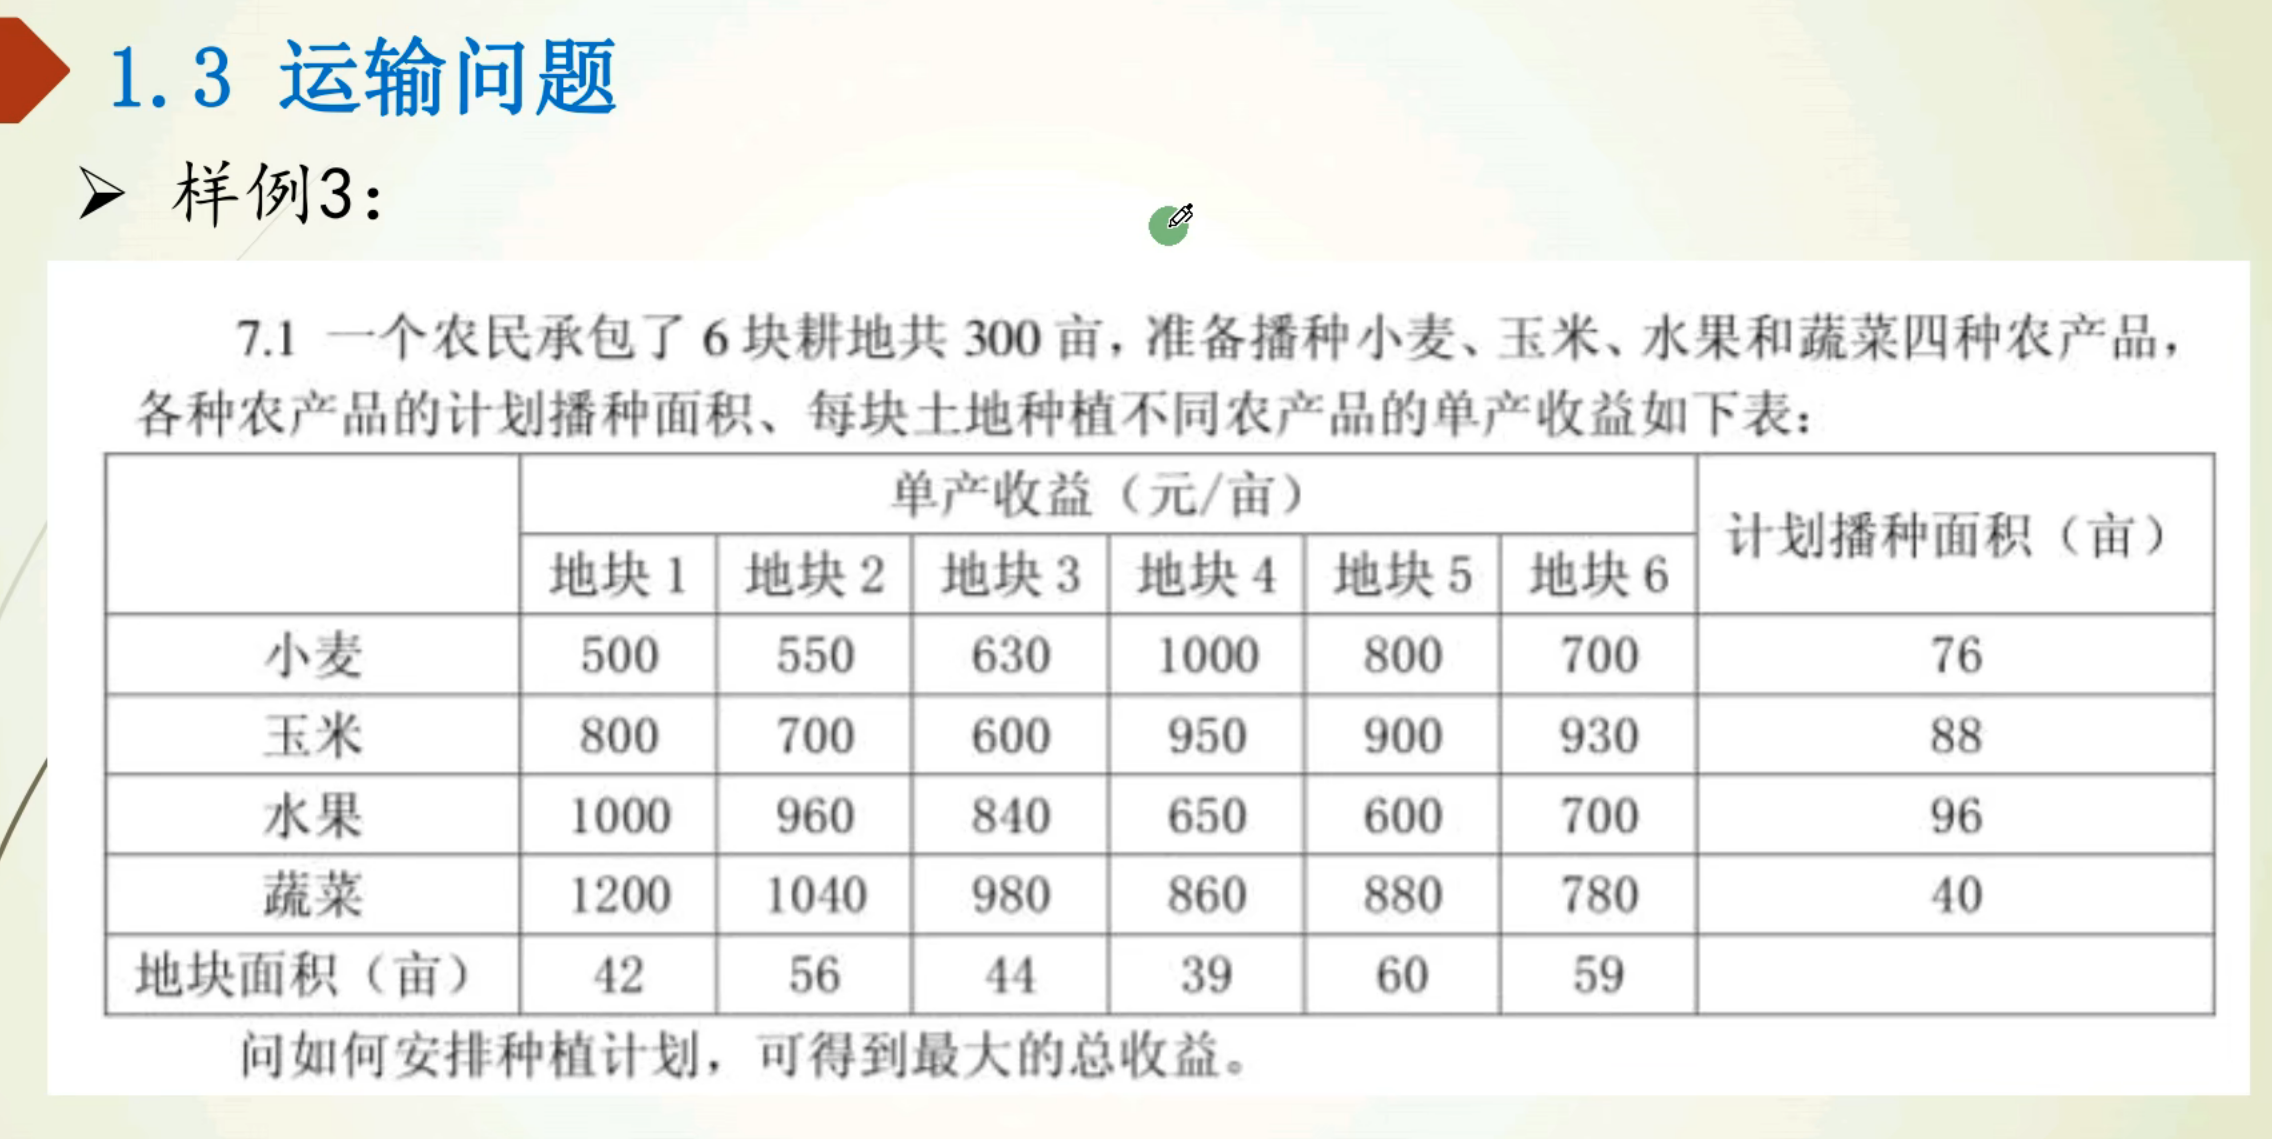![](./img/P4_5.png)

In [10]:
import pulp
import numpy as np
from pprint import pprint
def transportation_problem(costs, x_max, y_max):
    row = len(costs)
    col = len(costs[0])
    prob = pulp.LpProblem('Transportation Problem', sense = pulp.LpMaximize)
    var = [[pulp.LpVariable(f'x{i}{j}', lowBound=0, cat=pulp.LpInteger) for j in range(col)] for i in range(row)]
    flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x] # 折叠成1维
    prob += pulp.lpDot(flatten(var), costs.flatten())
    for i in range(row):
        prob += (pulp.lpSum(var[i]) <= x_max[i])
    for j in range(col):
        prob += (pulp.lpSum([var[i][j] for i in range(row)]) <= y_max[j])
    prob.solve()
    return {'objective':pulp.value(prob.objective), 'var':[[pulp.value(var[i][j]) for j in range(col)] for i in range(row)]}

costs = np.array([[500, 550, 630, 1000, 800, 700],
                  [800, 700, 600, 950, 900, 930],
                  [1000, 960, 840, 650, 600, 700],
                  [1200, 1040, 980, 860, 880, 780]])
max_plant = [76, 88, 96, 40]
max_cultivation = [42, 56, 44, 39, 60, 59]
res = transportation_problem(costs, max_plant, max_cultivation)
print(f'最大值为{res["objective"]}')
print('各变量的取值为：')
pprint(res['var'])

最大值为284230.0
各变量的取值为：
[[0.0, 0.0, 6.0, 39.0, 31.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 29.0, 59.0],
 [2.0, 56.0, 38.0, 0.0, 0.0, 0.0],
 [40.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


D:\anaconda3\envs\swin\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


![](./img/P4_6.png)

In [2]:
# 2.1 分支定界代码

import math
from scipy.optimize import linprog
import sys

def integerPro(c, A, b, Aeq, beq, t=1e-8):
    res = linprog(c, A_ub=A, b_ub=b, A_eq=Aeq, b_eq=beq)
    #if(type(res.x) is float):
    #    bestX = [sys.maxsize]*len(c)
    #else:
    #    bestX = res.x
    bestX = res.x
    bestVal = sum([x*y for x,y in zip(c, bestX)])
    if all(((x-math.floor(x))<t or (math.ceil(x)-x)<t) for x in bestX):
        return (bestVal, bestX)
    else:
        ind = [i for i, x in enumerate(bestX) if (x-math.floor(x))>t and (math.ceil(x)-x)>t][0]
        newCon1 = [0]*len(A[0])
        newCon2 = [0]*len(A[0])
        newCon1[ind] = -1
        newCon2[ind] = 1
        newA1 = A.copy()
        newA2 = A.copy()
        newA1.append(newCon1)
        newA2.append(newCon2)
        newB1 = b.copy()
        newB2 = b.copy()
        newB1.append(-math.ceil(bestX[ind]))
        newB2.append(math.floor(bestX[ind]))
        r1 = integerPro(c, newA1, newB1, Aeq, beq)
        r2 = integerPro(c, newA2, newB2, Aeq, beq)
        if r1[0] < r2[0]:
            return r1
        else:
            return r2

c = [3, 4, 1]
A = [[-1, -6, -2], [-2, 0, 0]]
b = [-5, -3]
Aeq = [[0, 0, 0]]
beq = [0]
print(integerPro(c, A, b, Aeq, beq))
            

(0.0, array([0., 0., 0.]))


## ***上述代码有误*** 

![](./img/P4_7.png)

### 样例3：计算1/x+x的最小值

In [3]:
from scipy.optimize import minimize 
import numpy as np
#计算 1/x+x的最小值
def fun(args):
    a=args
    v=lambda x:a/x[0] + x[0]
    return v

args = (1) # a
x0 = np.asarray((2)) # 初始猜测值
res = minimize(fun(args), x0, method='SLSQP')
print(res.fun)
print(res.success)
print(res.x)

2.0000000815356342
True
[1.00028559]


## 样例4：计算（2+x1)/(1+x2)-3x1+4x3的最小值，其中x1、x2、x3范围在0.1到0.9之间

In [4]:
from scipy.optimize import minimize
import numpy as np
# 计算 (2+x1)/(1+x2) - 3*x1+4-x3 的最小值 x1、x2、x3的范围都在 0.1到0.9之间
def fun(args):
    a, b, c, d = args
    v = lambda x: (a+x[0])/(b+x[1]) - c*x[0]+d*x[2]
    return v

def con(args):
    # 约束条件 分为eq 和ineq
    # eq表示函数结果等于0；ineq表示表达式大于等于0
    x1min, x1max, x2min, x2max, x3min, x3max = args
    cons = ({'type':'ineq','fun':lambda x:x[0]-x1min},
            {'type':'ineq','fun':lambda x:-x[0]+x1max},
            {'type':'ineq','fun':lambda x:x[1]-x2min},
            {'type':'ineq','fun':lambda x:-x[1]+x2max},
            {'type':'ineq','fun':lambda x:x[2]-x3min},
            {'type':'ineq','fun':lambda x:-x[2]+x3max})
    return cons

# 定义常量值
args = (2, 1, 3, 4)  # a, b, c, d
# 设置参数范围/约束条件
args1 = (0.1, 0.9, 0.1, 0.9, 0.1, 0.9)  # x1min, x1max, x2min, x2max, x3min, x3max
cons = con(args1)
# 设置初始猜测值
x0 = np.asarray((0.5, 0.5, 0.5))
res = minimize(fun(args), x0, method='SLSQP', constraints=cons)
print(res.fun)
print(res.success)
print(res.x)

-0.773684210526435
True
[0.9 0.9 0.1]
